In [1]:
import os
import cv2
import glob
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split
import random
import pickle
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('HousesDataset/HousesInfo.txt', header=None, sep=' ', names=['bedrooms', 'bathrooms', 'area', 'zipcode', 'price'])

In [3]:
data.head()

,bedrooms,bathrooms,area,zipcode,price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
3,5,5.0,4022,85262,910000
4,3,4.0,4116,85266,971226


In [4]:
data.index.values + 1

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [5]:
list(sorted(glob.glob(os.path.sep.join(['HousesDataset', "{}_*".format(1)]))))

['HousesDataset\\1_bathroom.jpg',
 'HousesDataset\\1_bedroom.jpg',
 'HousesDataset\\1_frontal.jpg',
 'HousesDataset\\1_kitchen.jpg']

In [6]:
basepath = os.path.sep.join(['HousesDataset', "{}_*".format(1)])
imgPaths = list(sorted(glob.glob(basepath)))
inputImages = []
for imgPath in imgPaths:
    image = cv2.resize(cv2.imread(imgPath), (32, 32))
    inputImages.append(image)
np.shape(inputImages)

(4, 32, 32, 3)

In [7]:
images = []
for i in data.index.values:
    basepath = os.path.sep.join(['HousesDataset', "{}_*".format(i + 1)])
    imgPaths = list(sorted(glob.glob(basepath)))
    inputImages = []
    for imgPath in imgPaths:
        image = cv2.resize(cv2.imread(imgPath), (32, 32))
        inputImages.append(image)
    outputImage = np.zeros((64, 64, 3), dtype='uint8')
    outputImage[0:32, 0:32] = inputImages[0]
    outputImage[0:32, 32:64] = inputImages[1]
    outputImage[32:64, 32:64] = inputImages[2]
    outputImage[32:64, 0:32] = inputImages[3]
    images.append(outputImage)

In [8]:
images = np.array(images)
images.shape

(535, 64, 64, 3)

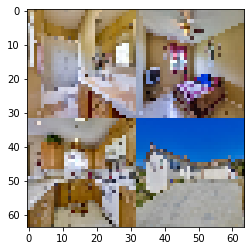

In [9]:
plt.imshow(images[100][..., ::-1])

In [10]:
images[0]

array([[[106, 146, 170],
        [ 94, 139, 166],
        [125, 169, 189],
        ...,
        [ 77, 131, 160],
        [ 87,  87, 117],
        [ 30,  34,  59]],

       [[145, 182, 189],
        [107, 158, 176],
        [ 97, 138, 168],
        ...,
        [ 28,  33,  63],
        [ 81,  86, 119],
        [ 71,  99, 133]],

       [[137, 176, 190],
        [ 81, 128, 154],
        [119, 162, 181],
        ...,
        [ 13,  12,  38],
        [ 68,  75, 102],
        [143, 128, 142]],

       ...,

       [[198, 182, 189],
        [181, 160, 175],
        [  7,  31,  93],
        ...,
        [132, 126, 126],
        [174, 156, 154],
        [177, 171, 168]],

       [[160, 157, 173],
        [172, 167, 182],
        [ 13,  46, 110],
        ...,
        [188, 169, 167],
        [173, 156, 149],
        [172, 137, 122]],

       [[174, 181, 196],
        [202, 175, 179],
        [  2,   4,  46],
        ...,
        [173, 164, 168],
        [138, 116,  96],
        [ 91,  85,  73]]

In [11]:
X_train, X_test, IX_train, IX_test = train_test_split(data, images, random_state=1234)

In [12]:
X_train['price']

166     699700
499    1495000
307     675000
189     729000
123     699800
        ...   
279     519900
372      74900
204     649000
53      249900
294     385000
Name: price, Length: 401, dtype: int64

In [13]:
max_price = X_train['price'].max()
y_train = X_train['price'] / max_price
y_test = X_test['price'] / max_price

In [14]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import concatenate, Input, Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization, Activation, Dropout

In [15]:
input1 = Input(shape=(64, 64, 3))
conv1 = Conv2D(16, (3, 3), padding='same', activation='relu')(input1)
batchnorm1 = BatchNormalization(axis=-1)(conv1)
maxpool1 = MaxPool2D(pool_size=(2, 2))(batchnorm1)
conv2 = Conv2D(32, (3, 3), padding='same', activation='relu')(maxpool1)
batchnorm2 = BatchNormalization(axis=-1)(conv2)
maxpool2 = MaxPool2D(pool_size=(2, 2))(batchnorm2)
conv3 = Conv2D(64, (3, 3), padding='same', activation='relu')(maxpool2)
batchnorm3 = BatchNormalization(axis=-1)(conv3)
maxpool3 = MaxPool2D(pool_size=(2, 2))(batchnorm3)
flatten1 = Flatten()(maxpool3)
dense1 = Dense(32, activation='relu')(flatten1)
batchnorm4 = BatchNormalization(axis=-1)(dense1)
dropout1 = Dropout(0.5)(batchnorm4)
dense2 = Dense(16, activation='relu')(dropout1)

In [16]:
m1 = Model(input1, dense2)

In [17]:
m1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128   

In [18]:
ss = StandardScaler()
XT = ss.fit_transform(X_train[['bedrooms', 'bathrooms', 'area']])
Xt = ss.transform(X_test[['bedrooms', 'bathrooms', 'area']])

In [19]:
lb = LabelBinarizer()
lb.fit(data['zipcode'])
XTz = lb.transform(X_train['zipcode'])
Xtz = lb.transform(X_test['zipcode'])

In [20]:
XTz[100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0])

In [21]:
XT = np.hstack([XT, XTz])
Xt = np.hstack([Xt, Xtz])

In [22]:
XT[100]

array([-0.31858977, -0.69358105,  0.26909095,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ])

In [23]:
XT.shape

(401, 52)

In [24]:
Xt.shape

(134, 52)

In [25]:
m2 = Sequential()
m2.add(Dense(16, activation='relu', input_dim=52))
m2.add(Dropout(0.5))
m2.add(Dense(8, activation='relu'))
m2.add(Dense(4, activation='relu'))

In [26]:
m2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                848       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 4)                 36        
                                                                 
Total params: 1,020
Trainable params: 1,020
Non-trainable params: 0
_________________________________________________________________


In [27]:
combineModel = concatenate([m2.output, m1.output])

In [28]:
densef1 = Dense(8, activation='relu')(combineModel)
densef2 = Dense(1, activation='linear')(densef1)
model = Model(inputs=[m2.input, m1.input], outputs=densef2)

In [29]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 16)   448         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 16)  64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 32, 16)   0           ['batch_normalization[0][0]

In [30]:
from tensorflow.keras.utils import plot_model

In [31]:
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [32]:
model.compile(optimizer='adam', loss='mean_absolute_error')

In [33]:
model.fit([XT, IX_train], y_train, validation_data=([Xt, IX_test], y_test), epochs=100, batch_size=10)

Epoch 1/100
41/41 [==============================] - 3s 45ms/step - loss: 0.3977 - val_loss: 1.0994
Epoch 2/100
41/41 [==============================] - 1s 28ms/step - loss: 0.2123 - val_loss: 0.1379
Epoch 3/100
41/41 [==============================] - 1s 27ms/step - loss: 0.1356 - val_loss: 0.0921
Epoch 4/100
41/41 [==============================] - 1s 26ms/step - loss: 0.1165 - val_loss: 0.0900
Epoch 5/100
41/41 [==============================] - 1s 26ms/step - loss: 0.0891 - val_loss: 0.0868
Epoch 6/100
41/41 [==============================] - 1s 27ms/step - loss: 0.0861 - val_loss: 0.0849
Epoch 7/100
41/41 [==============================] - 1s 25ms/step - loss: 0.0839 - val_loss: 0.0848
Epoch 8/100
41/41 [==============================] - 1s 26ms/step - loss: 0.0766 - val_loss: 0.0847
Epoch 9/100
41/41 [==============================] - 1s 27ms/step - loss: 0.0771 - val_loss: 0.0837
Epoch 10/100
41/41 [==============================] - 1s 26ms/step - loss: 0.0756 - val_loss: 0.0831

41/41 [==============================] - 1s 26ms/step - loss: 0.0317 - val_loss: 0.0627
Epoch 83/100
41/41 [==============================] - 1s 27ms/step - loss: 0.0298 - val_loss: 0.0529
Epoch 84/100
41/41 [==============================] - 1s 26ms/step - loss: 0.0286 - val_loss: 0.0525
Epoch 85/100
41/41 [==============================] - 1s 26ms/step - loss: 0.0278 - val_loss: 0.0532
Epoch 86/100
41/41 [==============================] - 1s 26ms/step - loss: 0.0280 - val_loss: 0.0543
Epoch 87/100
41/41 [==============================] - 1s 27ms/step - loss: 0.0289 - val_loss: 0.0522
Epoch 88/100
41/41 [==============================] - 1s 26ms/step - loss: 0.0300 - val_loss: 0.0515
Epoch 89/100
41/41 [==============================] - 1s 26ms/step - loss: 0.0294 - val_loss: 0.0506
Epoch 90/100
41/41 [==============================] - 1s 26ms/step - loss: 0.0274 - val_loss: 0.0523
Epoch 91/100
41/41 [==============================] - 1s 26ms/step - loss: 0.0295 - val_loss: 0.0522
Epo

In [34]:
predicts = model.predict([Xt, IX_test]) * max_price

5/5 [==============================] - 0s 17ms/step


In [35]:
predicts.flatten()

array([ 770522.35603333,  533561.70654297,  923186.18297577,
       1380246.87767029,  224455.19268513,  862300.99201202,
        466978.81817818, 1115710.85453033,  346772.9985714 ,
        319358.31904411,  619065.52314758,  350468.1289196 ,
        669421.01716995,  671157.00244904,  969587.80288696,
        351962.68558502,  513524.88994598,  564688.68255615,
        508026.9575119 ,  177637.21942902, 1128796.33903503,
        289158.94031525,  363350.80862045,  736851.811409  ,
        603722.21469879,  372119.30751801,  362507.93933868,
        650130.62953949,  632070.60098648,  704252.00462341,
        439023.43511581,  520064.83078003,  687122.3449707 ,
        501139.93883133,  547941.32709503,  463480.56197166,
        917808.65192413, 1136771.67892456,  258823.21596146,
        140024.00636673,  372853.48773003,  597189.6648407 ,
        752468.10913086, 1259317.99411774,  485507.90548325,
        768973.46973419,  494352.60891914,  734020.94841003,
        808627.12860107,

In [36]:
y_test.values * max_price

array([ 490000.,  389900., 1039000., 1595000.,   69800.,  799900.,
        329900., 1499000.,  104900.,  196000.,  895000.,  335000.,
        284900., 1199000., 1895000.,  275000.,  265000.,  560000.,
        510000.,   89500.,  759000.,  534888.,  520000.,  949000.,
       5858000.,  450000.,  385000.,  949000.,  289900.,  625000.,
        250000.,  625000.,  299000.,  549000.,  580000.,  330000.,
        897000., 1200000.,  279900.,  189000.,  425000.,  629000.,
        949000., 2150000.,  999000.,  685000.,  380000.,  765000.,
       1195000.,  664900.,  875000.,  479000.,  895000.,  104900.,
        499000.,   79900., 1500000.,  489000., 1595000., 1795000.,
        557000., 1080000.,  219500.,  515000.,  825500., 1698000.,
        117000.,  303590.,  449000.,  469900.,  625000.,  541000.,
         36000.,  569950.,   84900.,  899900.,  499000.,   87500.,
        167400.,  218000.,  515000.,  530000.,  889000.,  799900.,
        110000., 1299000.,  647000.,  979000.,  475000.,  1790

In [37]:
diff = abs(predicts.flatten() - (y_test.values * max_price))
diff

array([2.80522356e+05, 1.43661707e+05, 1.15813817e+05, 2.14753122e+05,
       1.54655193e+05, 6.24009920e+04, 1.37078818e+05, 3.83289145e+05,
       2.41872999e+05, 1.23358319e+05, 2.75934477e+05, 1.54681289e+04,
       3.84521017e+05, 5.27842998e+05, 9.25412197e+05, 7.69626856e+04,
       2.48524890e+05, 4.68868256e+03, 1.97304249e+03, 8.81372194e+04,
       3.69796339e+05, 2.45729060e+05, 1.56649191e+05, 2.12148189e+05,
       5.25427779e+06, 7.78806925e+04, 2.24920607e+04, 2.98869370e+05,
       3.42170601e+05, 7.92520046e+04, 1.89023435e+05, 1.04935169e+05,
       3.88122345e+05, 4.78600612e+04, 3.20586729e+04, 1.33480562e+05,
       2.08086519e+04, 6.32283211e+04, 2.10767840e+04, 4.89759936e+04,
       5.21465123e+04, 3.18103352e+04, 1.96531891e+05, 8.90682006e+05,
       5.13492095e+05, 8.39734697e+04, 1.14352609e+05, 3.09790516e+04,
       3.86372871e+05, 2.21623624e+05, 1.18346334e+05, 1.09478565e+05,
       2.05315728e+05, 1.40285882e+05, 5.36538458e+03, 1.90503147e+05,
      

In [38]:
diff.mean()

207911.43817864248

In [39]:
data['price'].mean()

589362.8112149533

In [40]:
data['price'].std()

509026.06764905644

In [41]:
from sklearn.metrics import r2_score, mean_absolute_error

In [42]:
r2_score(y_true=(y_test.values * max_price), y_pred=predicts.flatten())

0.26383236766492946

In [43]:
abs(model.predict([Xt, IX_test]).flatten() - y_test).mean() * max_price

5/5 [==============================] - 0s 18ms/step


207911.4381786424